In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d karakaggle/kaggle-cat-vs-dog-dataset

Dataset URL: https://www.kaggle.com/datasets/karakaggle/kaggle-cat-vs-dog-dataset
License(s): unknown
 99% 782M/787M [00:07<00:00, 121MB/s]
100% 787M/787M [00:07<00:00, 108MB/s]


In [ ]:
from zipfile import ZipFile
dataset = '/content/kaggle-cat-vs-dog-dataset.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()

In [ ]:
!ls

kagglecatsanddogs_3367a  kaggle-cat-vs-dog-dataset.zip	mobile.h5  sample_data


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split


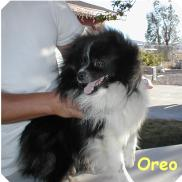

In [ ]:
img = cv2.imread('/content/kagglecatsanddogs_3367a/PetImages/Dog/10047.jpg')
display = cv2_imshow(img)

In [ ]:
cat_path = '/content/kagglecatsanddogs_3367a/PetImages/Cat'
dog_path = '/content/kagglecatsanddogs_3367a/PetImages/Dog'

data = []
labels = []
failed_images = []

def process_images(image_list, base_path, label):
    count = 0
    for img_name in image_list:
        img_path = os.path.join(base_path, img_name)
        image = cv2.imread(img_path)
        if image is not None:
            image = cv2.resize(image, (224, 224))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            data.append(image)
            labels.append(label)
            count += 1
        else:
            failed_images.append(img_path)
    return count


cat_images = os.listdir(cat_path)
cat_count = process_images(cat_images[:500], cat_path, 0)

dog_images = os.listdir(dog_path)
dog_count = process_images(dog_images[:500], dog_path, 1)

print(f"Successfully processed {cat_count} cat images and {dog_count} dog images.")
print(f"Total images in data list: {len(data)}")
print(f"Failed to process {len(failed_images)} images:")
for failed_image in failed_images:
    print(failed_image)

x = np.array(data)
y = np.array(labels)

print(f"Shape of x: {x.shape}")
print(f"Shape of y: {y.shape}")


Successfully processed 499 cat images and 499 dog images.
Total images in data list: 998
Failed to process 2 images:
/content/kagglecatsanddogs_3367a/PetImages/Cat/11210.jpg
/content/kagglecatsanddogs_3367a/PetImages/Dog/6059.jpg
Shape of x: (998, 224, 224, 3)
Shape of y: (998,)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=2)

In [ ]:
x_train = x_train/255
x_test = x_test/255

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
mobilenet_model = "https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/tf2-preview-feature-vector/versions/4"


In [ ]:
pretrained = hub.KerasLayer(mobilenet_model, input_shape=(224,224,3),trainable= False)

In [ ]:
classes = 2
model = tf.keras.Sequential([
    pretrained,
    tf.keras.layers.Dense(classes)
])


In [ ]:
model.compile(
    optimizer= 'adam',
    loss = 'SparseCategoricalCrossentropy',
    metrics = ['accuracy']
)

In [ ]:
model.fit(x_train,y_train,epochs=10)

Epoch 1/10
25/25 [==============================] - 33s 1s/step - loss: 1.5584 - accuracy: 0.8108
Epoch 2/10
25/25 [==============================] - 27s 1s/step - loss: 0.1985 - accuracy: 0.9649
Epoch 3/10
25/25 [==============================] - 28s 1s/step - loss: 0.1386 - accuracy: 0.9799
Epoch 4/10
25/25 [==============================] - 28s 1s/step - loss: 0.1448 - accuracy: 0.9862
Epoch 5/10
25/25 [==============================] - 28s 1s/step - loss: 0.3322 - accuracy: 0.9411
Epoch 6/10
25/25 [==============================] - 28s 1s/step - loss: 0.3514 - accuracy: 0.9298
Epoch 7/10
25/25 [==============================] - 26s 1s/step - loss: 0.2895 - accuracy: 0.9762
Epoch 8/10
25/25 [==============================] - 27s 1s/step - loss: 0.2892 - accuracy: 0.9837
Epoch 9/10
25/25 [==============================] - 28s 1s/step - loss: 0.2927 - accuracy: 0.9850
Epoch 10/10
25/25 [==============================] - 28s 1s/step - loss: 0.2927 - accuracy: 0.9850


In [ ]:
score, acc = model.evaluate(x_test,y_test)

7/7 [==============================] - 14s 2s/step - loss: 0.2916 - accuracy: 0.9550


In [ ]:
model.save("/content/mobile.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
model = tf.keras.models.load_model('mobile.h5', custom_objects={'KerasLayer': hub.KerasLayer})

In [ ]:
X_train_features = model.predict(x_train)
X_test_features = model.predict(x_test)

7/7 [==============================] - 6s 805ms/step


In [ ]:
print(X_train_features)
X_train_features.shape

[[-0.18423471  1.6134572 ]
 [ 0.8982447   1.3270836 ]
 [ 0.69847035  1.1627738 ]
 ...
 [ 1.0280802   1.5144398 ]
 [-0.63039887 -0.88488024]
 [ 0.24406755  2.519036  ]]


(798, 2)

In [ ]:
print(X_test_features)

[[ 1.21144012e-01  1.42160106e+00]
 [-7.81421304e-01 -6.01268828e-01]
 [-1.22561932e+00  8.38356197e-01]
 [-2.02414975e-01 -1.29449832e+00]
 [ 3.12595844e-01  4.38758552e-01]
 [ 1.77751034e-01  5.82945943e-02]
 [-9.15303528e-01 -9.13901567e-01]
 [-1.33815610e+00  1.83152691e-01]
 [ 1.34226918e-01  9.66249585e-01]
 [-7.33865798e-03  7.27566242e-01]
 [ 5.72052717e-01  1.75347418e-01]
 [-9.09342587e-01 -7.99644291e-01]
 [ 6.59629166e-01 -8.62115204e-01]
 [-6.06550574e-02 -3.37640315e-01]
 [ 9.63609591e-02  5.06800890e-01]
 [ 9.16281343e-01  8.36625040e-01]
 [-1.03601551e+00 -5.32102644e-01]
 [ 1.53507292e-02 -4.85837072e-01]
 [ 9.70831335e-01  1.06192172e+00]
 [-1.97177351e-01 -1.22518575e+00]
 [ 1.31777897e-01  9.75843430e-01]
 [-7.92966664e-01  1.90168762e+00]
 [ 4.33079869e-01  5.43418705e-01]
 [ 3.32552493e-02 -4.62194383e-01]
 [-2.28641108e-02  1.47306967e+00]
 [-3.80587697e-01 -4.61233199e-01]
 [ 7.83456981e-01  4.64246273e-01]
 [-1.37918019e+00 -3.05901974e-01]
 [ 2.05831027e+00  1

In [ ]:
X_train_features1 = X_train_features.reshape(X_train_features.shape[0], -1)
X_test_features1 = X_test_features.reshape(X_test_features.shape[0], -1)

In [ ]:
print(X_train_features1)
X_train_features1.shape

[[-0.18423471  1.6134572 ]
 [ 0.8982447   1.3270836 ]
 [ 0.69847035  1.1627738 ]
 ...
 [ 1.0280802   1.5144398 ]
 [-0.63039887 -0.88488024]
 [ 0.24406755  2.519036  ]]


(798, 2)

In [ ]:
print(X_test_features1)

[[ 1.21144012e-01  1.42160106e+00]
 [-7.81421304e-01 -6.01268828e-01]
 [-1.22561932e+00  8.38356197e-01]
 [-2.02414975e-01 -1.29449832e+00]
 [ 3.12595844e-01  4.38758552e-01]
 [ 1.77751034e-01  5.82945943e-02]
 [-9.15303528e-01 -9.13901567e-01]
 [-1.33815610e+00  1.83152691e-01]
 [ 1.34226918e-01  9.66249585e-01]
 [-7.33865798e-03  7.27566242e-01]
 [ 5.72052717e-01  1.75347418e-01]
 [-9.09342587e-01 -7.99644291e-01]
 [ 6.59629166e-01 -8.62115204e-01]
 [-6.06550574e-02 -3.37640315e-01]
 [ 9.63609591e-02  5.06800890e-01]
 [ 9.16281343e-01  8.36625040e-01]
 [-1.03601551e+00 -5.32102644e-01]
 [ 1.53507292e-02 -4.85837072e-01]
 [ 9.70831335e-01  1.06192172e+00]
 [-1.97177351e-01 -1.22518575e+00]
 [ 1.31777897e-01  9.75843430e-01]
 [-7.92966664e-01  1.90168762e+00]
 [ 4.33079869e-01  5.43418705e-01]
 [ 3.32552493e-02 -4.62194383e-01]
 [-2.28641108e-02  1.47306967e+00]
 [-3.80587697e-01 -4.61233199e-01]
 [ 7.83456981e-01  4.64246273e-01]
 [-1.37918019e+00 -3.05901974e-01]
 [ 2.05831027e+00  1

In [ ]:
from sklearn.svm import SVC
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train_features1, y_train)



SVC(kernel='linear', random_state=42)

In [ ]:
y_pred = svm.predict(X_test_features1)
from sklearn.metrics import accuracy_score,classification_report
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')
print('Classification Report:')
print(classification_report(y_test, y_pred))


Accuracy: 79.00%
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.82      0.78        91
           1       0.84      0.76      0.80       109

    accuracy                           0.79       200
   macro avg       0.79      0.79      0.79       200
weighted avg       0.79      0.79      0.79       200



In [ ]:
from PIL import Image
def classify_image(image_path):
    img = Image.open(image_path)
    img = img.resize((224,224))
    img = img.convert('RGB')
    img = np.array(img)
    img = img/255.0
    img = img.reshape(1, 224, 224, 3)
    features = model.predict(img)
    features = features.reshape(1, -1)
    prediction = svm.predict(features)
    return 'Dog' if prediction == 1 else 'Cat'

# Example usage
print(classify_image('/content/kagglecatsanddogs_3367a/PetImages/Cat/10084.jpg'))

1/1 [==============================] - 0s 76ms/step
Cat


In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
def classify_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    features = model.predict(img)
    features = features.reshape(1, -1)
    prediction = svm.predict(features)
    return 'Dog' if prediction == 1 else 'Cat'
image_path = '/content/kagglecatsanddogs_3367a/PetImages/Dog/10055.jpg'
prediction = classify_image(image_path)
print(f"The predicted label is: {prediction}")

1/1 [==============================] - 0s 166ms/step
The predicted label is: Dog


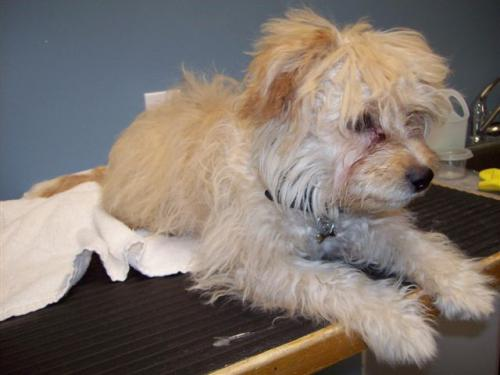

In [ ]:
img = cv2.imread(image_path)
display = cv2_imshow(img)